In [9]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [1]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)

import module

In [2]:
df = module.file_load.load_current_version()

In [3]:
df.shape, df['is_test'].value_counts()

((1126262, 53),
 0    1116990
 1       9272
 Name: is_test, dtype: int64)

In [4]:
module.preprocess.시_군_구_add(df)
module.preprocess.번지주소_add(df)
module.preprocess.날짜포맷_add(df)
module.parser.아파트_unique_key_add(df)
module.preprocess.평수_add(df)

In [5]:
df['최대평수'] = df.groupby('아파트_unique_key')['평수'].transform('max')
df['최대층'] = df.groupby('아파트_unique_key')['층'].transform('max')

In [6]:
# 층수 구간과 레이블 정의
bins = [-float('inf'), 0, 10, 20, 30, 50, 60, float('inf')]  # 경계값 설정
labels = ['지하', '10미만', '10이상-20미만', '20이상-30미만', '30이상-50미만', '50이상-60미만', '60이상']  # 레이블 설정

# 층수 그룹화
df['층_그룹'] = pd.cut(df['층'], bins=bins, labels=labels, right=False)

In [7]:
print(df['층_그룹'].value_counts().sort_index())

지하              254
10미만         666975
10이상-20미만    398654
20이상-30미만     54250
30이상-50미만      5811
50이상-60미만       237
60이상             81
Name: 층_그룹, dtype: int64


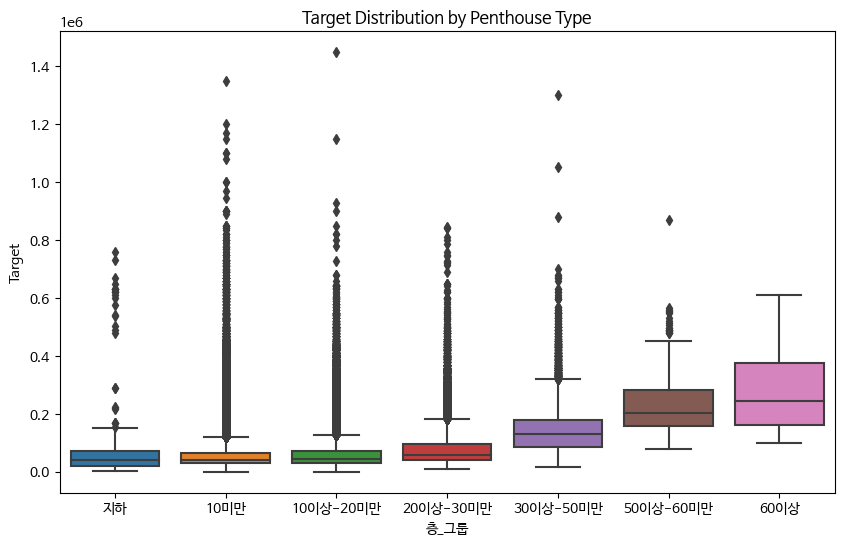

In [10]:
# 펜트하우스_타입에 따른 target 비교
plt.figure(figsize=(10, 6))
sns.boxplot(x='층_그룹', y='target', data=df)
plt.title('Target Distribution by Penthouse Type')
plt.xlabel('층_그룹')
plt.ylabel('Target')
plt.show()


In [11]:
# 100 이상, 90이상 , 80 이상, 70이상, 60이상, 50이상, 40이상, 30이상, 20이상, 10이상, 10미만
# 평수 구간 및 레이블 정의
bins = [-float('inf'), 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
labels = ['10미만', '10이상-20미만', '20이상-30미만', '30이상-40미만', 
          '40이상-50미만', '50이상-60미만', '60이상-70미만', 
          '70이상-80미만', '80이상-90미만', '90이상-100미만', '100이상']

# 평수 그룹화
df['평수_그룹'] = pd.cut(df['평수'], bins=bins, labels=labels, right=False)


In [12]:
# 그룹별 카운트
평수별_카운트 = df['평수_그룹'].value_counts().sort_index()

# 결과 출력
print(평수별_카운트)


10미만           33605
10이상-20미만     438912
20이상-30미만     475694
30이상-40미만     123559
40이상-50미만      40072
50이상-60미만       9053
60이상-70미만       3108
70이상-80미만       2146
80이상-90미만        101
90이상-100미만        10
100이상              2
Name: 평수_그룹, dtype: int64


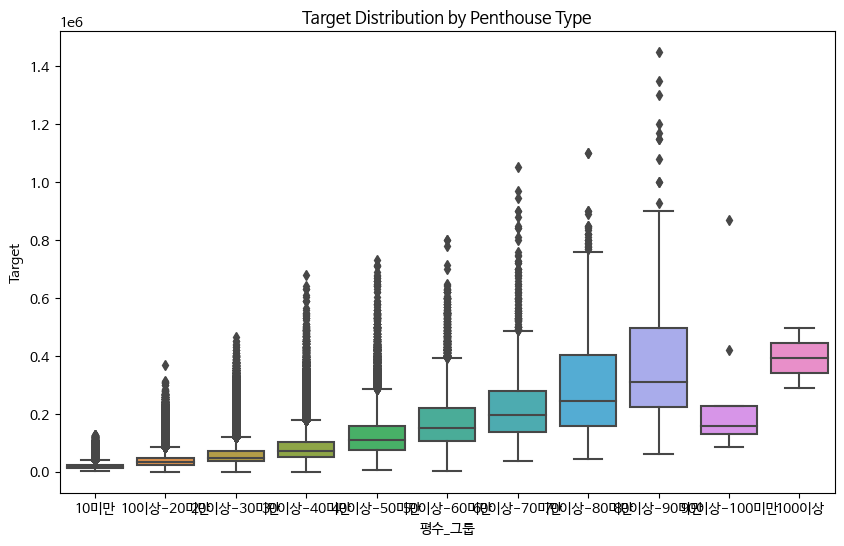

In [13]:
# 펜트하우스_타입에 따른 target 비교
plt.figure(figsize=(10, 6))
sns.boxplot(x='평수_그룹', y='target', data=df)
plt.title('Target Distribution by Penthouse Type')
plt.xlabel('평수_그룹')
plt.ylabel('Target')
plt.show()


In [14]:
df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
       'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '금리_단기1년전차이', '1차역세권', '2차역세권',
       '1차버스정류장', '경과구분', 'is_test', '시', '구', '동', '번지주소', '계약연도', '계약월',
       '계약년월일', '아파트_unique_key', '평수', '최대평수', '최대층', '층_그룹', '평수_그룹'],
      dtype='object')

In [15]:
df.drop(['시', '구', '동', '번지주소', '계약연도', '계약월',
       '계약년월일', '아파트_unique_key', '최대평수', '최대층'], axis=1, inplace=True)

In [16]:
df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
       'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '금리_단기1년전차이', '1차역세권', '2차역세권',
       '1차버스정류장', '경과구분', 'is_test', '평수', '층_그룹', '평수_그룹'],
      dtype='object')

In [17]:
# module.save.save_version(df, 'v8')

v8.csv 파일이 저장되었습니다.
